In [4]:
print('what\'s up')

what's up


# notebook imports

In [5]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from PIL import Image
from bs4 import BeautifulSoup
import numpy as np
from sklearn.model_selection import train_test_split


%matplotlib inline

#  constants

In [6]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT =1
HAM_CAT = 0

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'


# Reading Files

In [7]:
stream = open(EXAMPLE_FILE)
message = stream.read()
stream.close()
print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [8]:
stream = open(EXAMPLE_FILE)

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line =='\n':
        is_body = True
        
stream.close()

email_body = '\n'.join(lines) # add to one string at the character
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [9]:
def generate_square(N):
    for my_number in range(N):
        yield my_number ** 2

In [10]:
for i in generate_square(3):
    print(i, end=' ->')

0 ->1 ->4 ->

In [11]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line =='\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines) # add to one string at the character
            yield file_name, email_body


In [12]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification })
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)
    

In [13]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

MESSAGE  \
00260.c75ce8b8d8bfc55723426979d260bf61  This is a Multipart MIME message. Since your m...   
00242.e030c8b1f053037aeffb062f3a34b523  \n\nDear Sir or Madam\n\n\n\nIn the past you h...   
00267.ef433fb350170f28a1567cbc24900e53  ATTN:\n\n\n\nI am Edward Mulete JR. the son of...   
00496.1a37de098f6c8847c3c7839d73cc7106  <html>\n\n<head>\n\n<title>Toy</title>\n\n</he...   
00031.a78bb452b3a7376202b5e62a81530449  Suppliers of Computers, Printers, etc. & Consu...   

                                        CATEGORY  
00260.c75ce8b8d8bfc55723426979d260bf61         1  
00242.e030c8b1f053037aeffb062f3a34b523         1  
00267.ef433fb350170f28a1567cbc24900e53         1  
00496.1a37de098f6c8847c3c7839d73cc7106         1  
00031.a78bb452b3a7376202b5e62a81530449         1

In [14]:
spam_emails.shape

(1898, 2)

In [15]:
non_spam_emails = df_from_directory(EASY_NONSPAM_1_PATH, 2)
non_spam_emails = non_spam_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, 2))
non_spam_emails.head()

MESSAGE  \
02259.75e1cd5cf4a8857fb04b58ff179bed51  URL: http://www.newsisfree.com/click/-5,853546...   
00427.49db73be9017efca7355ee80f173a26c  Jim Whitehead wrote:\n\n\n\n>Great, this is ha...   
01465.b1fa1feb0603eff01231fa4a5a74cf37  >Anyway I'm making good progress and my implem...   
01869.1eb8e1093d75d3694e00857f680fd768  URL: http://scriptingnews.userland.com/backiss...   
01341.34cf1021232db9d1c782888dcd1e5328  | \n\n| 0 hits here. :(\n\n| \n\n\n\nI also ge...   

                                        CATEGORY  
02259.75e1cd5cf4a8857fb04b58ff179bed51         2  
00427.49db73be9017efca7355ee80f173a26c         2  
01465.b1fa1feb0603eff01231fa4a5a74cf37         2  
01869.1eb8e1093d75d3694e00857f680fd768         2  
01341.34cf1021232db9d1c782888dcd1e5328         2

In [16]:
non_spam_emails.shape

(3901, 2)

In [17]:
data = pd.concat([spam_emails, non_spam_emails])

In [18]:
data.shape

(5799, 2)

# Data cleaning: checking for missing values

In [19]:
# check if any message body are null
data['MESSAGE'].isnull().values.any()

False

In [20]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [21]:
(data.MESSAGE.str.len() == 0).any().sum()

1

# locate empty emails 

In [22]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

# Remove System File entries from DataFrame

In [23]:
data.drop(['cmds'], inplace=True)

In [24]:
data.shape

(5796, 2)

## Add Document IDs to track emails in dataset

In [25]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [26]:
data.DOC_ID

00260.c75ce8b8d8bfc55723426979d260bf61       0
00242.e030c8b1f053037aeffb062f3a34b523       1
00267.ef433fb350170f28a1567cbc24900e53       2
00496.1a37de098f6c8847c3c7839d73cc7106       3
00031.a78bb452b3a7376202b5e62a81530449       4
                                          ... 
01299.21bf6f0946fe21adc3e99db3e541ee57    5791
01336.03d61f76f58b98d6c4c0f4f303994db4    5792
00490.9c5dd006a16b1e30c9162ba4b4b75ea8    5793
00231.8096ae53e70b1b72b5935b12b823597b    5794
00030.cc523265aefc37ee6ce3015d8ff6aa24    5795
Name: DOC_ID, Length: 5796, dtype: int64

In [27]:
#create an index column
data['FILE_NAME'] = data.index 
data.set_index('DOC_ID', inplace = True )
data.head()

MESSAGE  CATEGORY  \
DOC_ID                                                                
0       This is a Multipart MIME message. Since your m...         1   
1       \n\nDear Sir or Madam\n\n\n\nIn the past you h...         1   
2       ATTN:\n\n\n\nI am Edward Mulete JR. the son of...         1   
3       <html>\n\n<head>\n\n<title>Toy</title>\n\n</he...         1   
4       Suppliers of Computers, Printers, etc. & Consu...         1   

                                     FILE_NAME  
DOC_ID                                          
0       00260.c75ce8b8d8bfc55723426979d260bf61  
1       00242.e030c8b1f053037aeffb062f3a34b523  
2       00267.ef433fb350170f28a1567cbc24900e53  
3       00496.1a37de098f6c8847c3c7839d73cc7106  
4       00031.a78bb452b3a7376202b5e62a81530449

# Save to file using pandas

In [28]:
data.to_json(DATA_JSON_FILE)

In [29]:
# Number of spam messages visualised  (pie charts)

In [30]:
data.CATEGORY.value_counts()

2    3900
1    1896
Name: CATEGORY, dtype: int64

In [31]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_non_spam = data.CATEGORY.value_counts()[2]
print(amount_of_non_spam)

3900


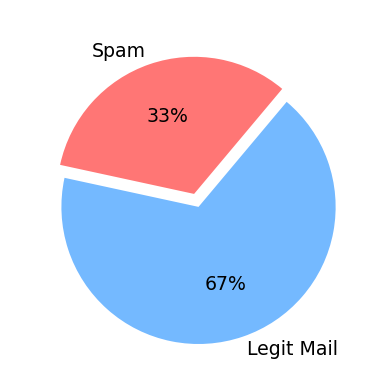

In [32]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_non_spam]
custom_colors = ['#ff7675', '#74b9ff' ]

plt.figure(figsize=(2,2), dpi=227 )
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle = 50, autopct='%1.0f%%', colors = custom_colors, explode = [0, 0.1] )
plt.show()

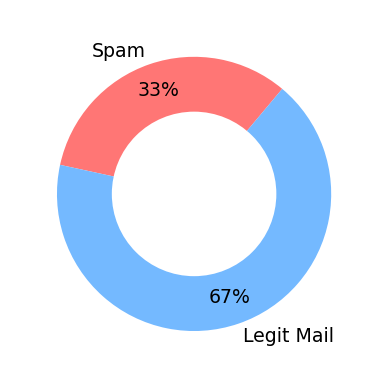

In [33]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_non_spam]
custom_colors = ['#ff7675', '#74b9ff' ]

plt.figure(figsize=(2,2), dpi=227 )
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle = 50, autopct='%1.0f%%', colors = custom_colors, pctdistance =0.8 )

#draw circle
centre_circle = plt.Circle( (0,0), radius = 0.6, fc = 'white')
plt.gca().add_artist(centre_circle)

plt.show()

# natural language processing

In [34]:
msg = 'All work and no play makes Jack a dull boy'
msg.lower()

'all work and no play makes jack a dull boy'

### Download the NLTK Resources

In [35]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/gian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to /home/gian/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to /home/gian/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## tokenising

In [38]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. ??? Nobody expects the Spanish Inquisition'
word_tokenize(msg)

['All',
 'work',
 'and',
 'no',
 'play',
 'makes',
 'Jack',
 'a',
 'dull',
 'boy',
 '.',
 'To',
 'be',
 'or',
 'not',
 'to',
 'be',
 '.',
 '?',
 '?',
 '?',
 'Nobody',
 'expects',
 'the',
 'Spanish',
 'Inquisition']

## removing stop words & word stems and stemming

In [39]:
stop_words = stopwords.words('english')

In [40]:
words = word_tokenize(msg.lower())
filtered_words = []
stemmer = PorterStemmer()

for word in words:
    if word not in stop_words and word.isalpha() :
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

In [41]:
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## removing html tags

In [42]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

ATTN:



I am Edward Mulete JR. the son of Mr. 



STEVE MBEKI MULETE from Zimbabwe. I am sorry this mail

Will surprise you, though we do not know, my mother Mrs. Clara 

Got your contact through her private search.

Due to the current war against white farmers in

Zimbabwe and the support of President Robert Mugabe to

Claim all white owned farms in our country to gain

Favor for re-election.



All white farmers were asked to

Surrender their farms to the government for

Re-distribution and infact to his political party

Members and my father though black was the treasury

of the farmers association and a strong member of an

Opposition party that did not support the president

Idea. He then ordered his party members and the police

Under his pay row to invade my father's farm and burn

Down everything in the farm. They killed my

Father and took away a lot of items from his farm.

After the death of my father, our local pastor and a

Close friend of my father handed us over will

D

In [43]:
soup.get_text()

"ATTN:\n\n\n\nI am Edward Mulete JR. the son of Mr. \n\n\n\nSTEVE MBEKI MULETE from Zimbabwe. I am sorry this mail\n\nWill surprise you, though we do not know, my mother Mrs. Clara \n\nGot your contact through her private search.\n\nDue to the current war against white farmers in\n\nZimbabwe and the support of President Robert Mugabe to\n\nClaim all white owned farms in our country to gain\n\nFavor for re-election.\n\n\n\nAll white farmers were asked to\n\nSurrender their farms to the government for\n\nRe-distribution and infact to his political party\n\nMembers and my father though black was the treasury\n\nof the farmers association and a strong member of an\n\nOpposition party that did not support the president\n\nIdea. He then ordered his party members and the police\n\nUnder his pay row to invade my father's farm and burn\n\nDown everything in the farm. They killed my\n\nFather and took away a lot of items from his farm.\n\nAfter the death of my father, our local pastor and a\n\nC

## Functions for Email Processing

In [44]:
def clean_message(message, stemmer=PorterStemmer(), stop_words = set(stopwords.words('english'))):
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    soup.get_text()    
    
    return filtered_words

In [45]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), stop_words = set(stopwords.words('english'))):
    message = BeautifulSoup(message, 'html.parser')
    message = message.get_text()
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [46]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['attn',
 'edward',
 'mulet',
 'son',
 'steve',
 'mbeki',
 'mulet',
 'zimbabw',
 'sorri',
 'mail',
 'surpris',
 'though',
 'know',
 'mother',
 'clara',
 'got',
 'contact',
 'privat',
 'search',
 'due',
 'current',
 'war',
 'white',
 'farmer',
 'zimbabw',
 'support',
 'presid',
 'robert',
 'mugab',
 'claim',
 'white',
 'own',
 'farm',
 'countri',
 'gain',
 'favor',
 'white',
 'farmer',
 'ask',
 'surrend',
 'farm',
 'govern',
 'infact',
 'polit',
 'parti',
 'member',
 'father',
 'though',
 'black',
 'treasuri',
 'farmer',
 'associ',
 'strong',
 'member',
 'opposit',
 'parti',
 'support',
 'presid',
 'idea',
 'order',
 'parti',
 'member',
 'polic',
 'pay',
 'row',
 'invad',
 'father',
 'farm',
 'burn',
 'everyth',
 'farm',
 'kill',
 'father',
 'took',
 'away',
 'lot',
 'item',
 'farm',
 'death',
 'father',
 'local',
 'pastor',
 'close',
 'friend',
 'father',
 'hand',
 'us',
 'document',
 'instruct',
 'father',
 'leav',
 'zimbabw',
 'incas',
 'anyth',
 'happen',
 'document',
 'certif',
 'd

## Apply Cleaning and Tokenisation to all messages

### slicing dataframes and Series and Creating subsets

In [47]:
data.iat[2, 2]

'00267.ef433fb350170f28a1567cbc24900e53'

In [48]:
data.iloc[0:2]

MESSAGE  CATEGORY  \
DOC_ID                                                                
0       This is a Multipart MIME message. Since your m...         1   
1       \n\nDear Sir or Madam\n\n\n\nIn the past you h...         1   

                                     FILE_NAME  
DOC_ID                                          
0       00260.c75ce8b8d8bfc55723426979d260bf61  
1       00242.e030c8b1f053037aeffb062f3a34b523

In [49]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [50]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]
        
len(flat_list)

412

In [51]:
%%time

nestedList = data.MESSAGE.apply(clean_msg_no_html)

/home/gian/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 27.2 s, sys: 0 ns, total: 27.2 s
Wall time: 27.2 s


## Using Logic to Slice Dataframes

In [52]:
data[data.CATEGORY ==1]


MESSAGE  CATEGORY  \
DOC_ID                                                                
0       This is a Multipart MIME message. Since your m...         1   
1       \n\nDear Sir or Madam\n\n\n\nIn the past you h...         1   
2       ATTN:\n\n\n\nI am Edward Mulete JR. the son of...         1   
3       <html>\n\n<head>\n\n<title>Toy</title>\n\n</he...         1   
4       Suppliers of Computers, Printers, etc. & Consu...         1   
...                                                   ...       ...   
1891    Protect Yourself.\n\n\n\nPurchase An Extended ...         1   
1892    <HTML><HEAD><TITLE>MILFhunter</TITLE>\n\n<META...         1   
1893    <META HTTP-EQUIV=3D"Content-Type" CONTENT=3D"t...         1   
1894    SPECIAL SITUATION ALERTS HOT PICK OF THE YEAR\...         1   
1895    <html>\n\n<script>open("http://www.cn1688.net/...         1   

                                     FILE_NAME  
DOC_ID                                          
0       00260.c75ce8b8d8bfc55723426979d260bf61  
1       00242.e030c8b1f053037aeffb062f3a34b523  
2       00267.ef433fb350170f28a1567cbc24900e53  
3       00496.1a37de098f6c8847c3c7839d73cc7106  
4       00031.a78bb452b3a7376202b5e62a81530449  
...                                        ...  
1891    01378.73df5252cb71f89c885ad49b6ae5fa82  
1892    01334.24b7f4702e0da7e9d7a5f4d284adfc96  
1893    00322.9c67ae5dc3348e9a0b9a61a408c3f44e  
1894    00488.e88c2c87a3b72ab47b6420b61279242e  
1895    00246.d314e68151f961425104dbe6a4e3bc9a  

[1896 rows x 3 columns]

In [53]:
doc_ids_spam = data[data.CATEGORY == 1].index

In [54]:
doc_ids_ham = data[data.CATEGORY == 2].index

### Subsetting a series with an index|

In [55]:
nested_list_ham = nestedList.loc[doc_ids_ham]

In [56]:
nested_list_spam = nestedList.loc[doc_ids_spam]

In [57]:
cleanWordsSpam = [item for entry in nested_list_spam for item in entry]
cleanWordsHam = [item for entry in nested_list_ham for item in entry]
normal_words = pd.Series(cleanWordsHam).value_counts()

In [58]:
print( len(cleanWordsSpam))
print(len(cleanWordsHam) )
normal_words[0:10]

317499
442079


http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

# Creating a Word Cloud

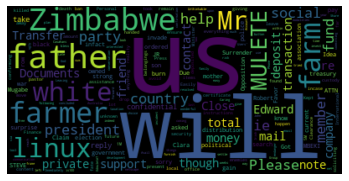

In [59]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')

word_cloud = WordCloud().generate(soup.prettify())
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [60]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')

In [61]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

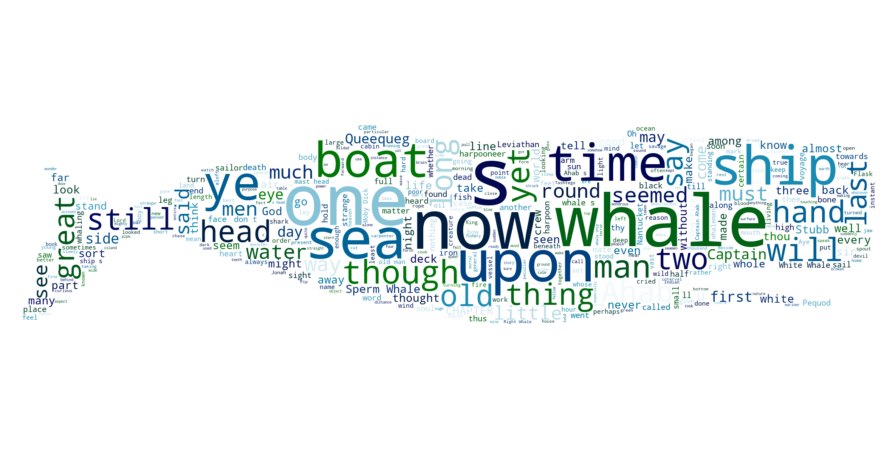

In [62]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB' ,size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask = rgb_array, background_color='white', 
                      max_words=400, colormap = 'ocean' )

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')
plt.show()

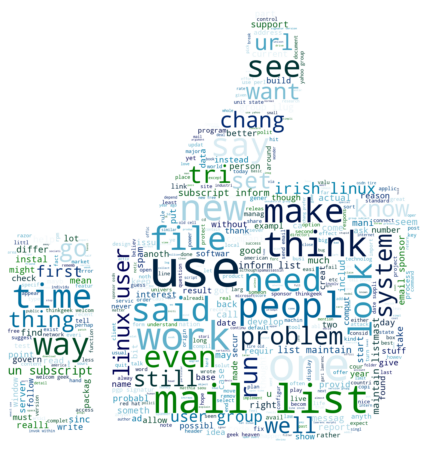

In [63]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB' ,size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

ham_str = ' '.join(cleanWordsHam)

word_cloud = WordCloud(mask = rgb_array, background_color='white', 
                      max_words=500, colormap = 'ocean' )

word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Generate vocabulary and dictionary

In [64]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

/home/gian/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [65]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print(unique_words)

http           10660
use             5019
list            4851
email           4367
get             4200
               ...  
pauli              1
hines              1
extig              1
prl                1
preparatori        1
Length: 27334, dtype: int64


In [66]:
frequent_words = unique_words[0: 2500]

## create vocabulry dataFrame

In [67]:
words_ids = list(range(0, 2500))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=words_ids )
vocab.index.name = 'WORD_ID'
vocab.head()

VOCAB_WORD
WORD_ID           
0             http
1              use
2             list
3            email
4              get

### Save the vocab as a csv file

In [68]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

In [69]:
'use' in set(vocab.VOCAB_WORD)
nestedList[0]

['multipart',
 'mime',
 'messag',
 'sinc',
 'mail',
 'reader',
 'understand',
 'format',
 'messag',
 'may',
 'legibl',
 'sucht',
 'pornodarstel',
 'wenn',
 'du',
 'spaß',
 'sex',
 'hast',
 'und',
 'nebenbei',
 'geld',
 'verdienen',
 'willst',
 'bewirb',
 'auch',
 'du',
 'dich',
 'wir',
 'suchen',
 'natürlich',
 'frauen',
 'und',
 'männer',
 'jeden',
 'alter',
 'mollig',
 'kein',
 'problem',
 'info',
 'unter',
 'au',
 'österreich',
 'au',
 'deutschland',
 'hier',
 'ein',
 'bild',
 'au',
 'einer',
 'produkt',
 'da',
 'vorstellungsvideo',
 'siehst',
 'du',
 'unter',
 'http',
 'solltest',
 'du',
 'unserem',
 'newslett',
 'kein',
 'interess',
 'mehr',
 'haben',
 'dann',
 'trage',
 'dich',
 'bitt',
 'au',
 'unter',
 'http',
 'attach',
 'agamaaaagaaaabibawabaaaaaqaaabobbqabaaaajaaaabsbbqabaaaalaaaacgbawabaaaa',
 'agauaaaapgeaaagrbwaeaaaaaqidaakrbqabaaaaugeaaasscgabaaaawgeaaawsbqabaaaa',
 'aqaaaayaaaapaqiabqaaahycaaaqaqiadaaaahwcaaasaqmaaqaaaaeaaacgkguaaqaaaigc',
 'aqebaqebaaaaaaaaaqidbaugbwgj

## EXERCISE: Find the email with the most number of words

In [70]:
nestedList

def most_lenghty(Series): 
    counter = 0
    listItem = Series[0] 
      
    for i in Series: 
        curr_length = len(i)
        if(curr_length > counter): 
            counter = curr_length
            listItem = i
  
    return len(listItem)
  
print(most_lenghty(nestedList)) 

7671


# Generate Features a Sparse Matrix

## Creating dataFrame with one word per Column

In [71]:
nestedList.to_list()

[['multipart',
  'mime',
  'messag',
  'sinc',
  'mail',
  'reader',
  'understand',
  'format',
  'messag',
  'may',
  'legibl',
  'sucht',
  'pornodarstel',
  'wenn',
  'du',
  'spaß',
  'sex',
  'hast',
  'und',
  'nebenbei',
  'geld',
  'verdienen',
  'willst',
  'bewirb',
  'auch',
  'du',
  'dich',
  'wir',
  'suchen',
  'natürlich',
  'frauen',
  'und',
  'männer',
  'jeden',
  'alter',
  'mollig',
  'kein',
  'problem',
  'info',
  'unter',
  'au',
  'österreich',
  'au',
  'deutschland',
  'hier',
  'ein',
  'bild',
  'au',
  'einer',
  'produkt',
  'da',
  'vorstellungsvideo',
  'siehst',
  'du',
  'unter',
  'http',
  'solltest',
  'du',
  'unserem',
  'newslett',
  'kein',
  'interess',
  'mehr',
  'haben',
  'dann',
  'trage',
  'dich',
  'bitt',
  'au',
  'unter',
  'http',
  'attach',
  'agamaaaagaaaabibawabaaaaaqaaabobbqabaaaajaaaabsbbqabaaaalaaaacgbawabaaaa',
  'agauaaaapgeaaagrbwaeaaaaaqidaakrbqabaaaaugeaaasscgabaaaawgeaaawsbqabaaaa',
  'aqaaaayaaaapaqiabqaaahycaaaqaq

In [72]:
word_column_df = pd.DataFrame.from_records(nestedList.to_list())
word_column_df.shape

(5796, 7671)

## Splitting the Data into a training and testing Dataset

In [73]:
training_data = word_column_df[0: 4057]

In [74]:
testing_data = word_column_df[4058: 5796]

In [75]:
X_train, X_test ,y_train, y_test = train_test_split(word_column_df, data.CATEGORY, test_size = 0.3, random_state = 42)

In [76]:
X_train.index.name = X_test.index.name = "DOC_ID"
X_train.head()


0       1     2       3         4         5         6        7     \
DOC_ID                                                                          
4844          hi  damian  suse   sparc   version  previous       run      sun   
4727     solocdm   wrote  four  differ      type   hostnam      link    separ   
5022      friday  august    pm   peter     wrote        hi  suddenli   anymor   
3504         url    http  date  suppli  contrari   popular    belief      new   
3921    hettinga   wrote   pgp    sign    messag      hash      geeg  schuman   

          8        9     ...  7661  7662  7663  7664  7665  7666  7667  7668  \
DOC_ID                   ...                                                   
4844     ultra    least  ...  None  None  None  None  None  None  None  None   
4727    option  program  ...  None  None  None  None  None  None  None  None   
5022     click    spell  ...  None  None  None  None  None  None  None  None   
3504     studi     show  ...  None  None  None  None  None  None  None  None   
3921     wrote     seem  ...  None  None  None  None  None  None  None  None   

        7669  7670  
DOC_ID              
4844    None  None  
4727    None  None  
5022    None  None  
3504    None  None  
3921    None  None  

[5 rows x 7671 columns]

In [77]:
word_index =  pd.Index(vocab.VOCAB_WORD)
word_index.get_loc('thu')

393

In [78]:

def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words of words ordered by word id
    labels: category (y_train or y_test)
    
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j] # ith row and jth columns
            if word in word_set: # if the word is within the frequent words
                doc_id = df.index[i] # the id of the email where the word is
                word_id = indexed_words.get_loc(word) #number
                category = labels.at[doc_id] #spam or ham
            
                #construct the dictionary
                item = { 'LABEL': category, 'DOC_ID' : doc_id,
                        'OCCURENCE': 1, 'word_id': word_id}
                
                dict_list.append(item)
                
    return pd.DataFrame(dict_list)

In [79]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)


CPU times: user 8min 48s, sys: 693 ms, total: 8min 49s
Wall time: 8min 49s


## Combine Occurrences with the pandas groupby() method

In [80]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'word_id', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID word_id LABEL           
0      0       1              2
       5       1              1
       10      1              2
       47      1              1
       75      1              1

In [81]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [82]:
data.MESSAGE[0]

'This is a Multipart MIME message. Since your mail reader\n\ndoes not understand this format, some or all of\n\nthis message may not be legible.\n\n\n\n--XX9ADB9A99-1A5B9ADBXX\n\nContent-Type: text/plain;\n\n\tcharset=iso-8859-1\n\nContent-Transfer-Encoding: 7bit\n\n\n\nK1-Erotikverlag sucht Pornodarsteller.\n\nWenn Du Spaß am Sex hast und nebenbei Geld verdienen willst, bewirb auch Du Dich. \n\nWir suchen natürliche Frauen und Männer, jeden Alters. Mollig - kein Problem.\n\nInfos unter: 0930 830 13 22 aus Österreich\n\n\n\n01 90 87 43 54 aus Deutschland\n\n1,86 Eu/Min.K1-Callcenter\n\n\n\nHier ein Bild aus einer Produktion.\n\nDas Vorstellungsvideo siehst Du unter:\n\nhttp://www.k1-web.com/Darsteller/index.php\n\n\n\nSolltest Du an unserem Newsletter kein Interesse\n\nmehr haben, dann trage Dich bitte aus unter:\n\nhttp://www.k1-web.com/newsletr.php\n\n\n\n--XX9ADB9A99-1A5B9ADBXX\n\nContent-Type: image/jpeg\n\nContent-Transfer-Encoding: base64\n\nContent-Disposition: attachment; filen

In [83]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

DOC_ID  word_id  LABEL  OCCURENCE
0       0        0      1          2
1       0        5      1          1
2       0       10      1          2
3       0       47      1          1
4       0       75      1          1

In [93]:
train_grouped.tail()

index  DOC_ID  word_id  LABEL  OCCURENCE
264677  264677    5795     1872      2          1
264678  264678    5795     2137      2          1
264679  264679    5795     2215      2          1
264680  264680    5795     2408      2          1
264681  264681    5795     2495      2          1

### Save Training data as .txt File

In [85]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

# Challenge: create sparse matrix for test data

In [86]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 3min 44s, sys: 216 ms, total: 3min 44s
Wall time: 3min 44s


In [92]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'word_id', 'LABEL']).sum()
test_grouped = test_grouped.reset_index()
np.savetxt(TESTING)

In [90]:
test_grouped.tail()

OCCURENCE
DOC_ID word_id LABEL           
5793   989     2              1
       1178    2              1
       1692    2              1
       1924    2              1
       2436    2              1

## Pre-Processing subleties and checking your understanding


In [91]:
train_odc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped )

AttributeError: 'DataFrame' object has no attribute 'DOC_ID'

len(test_doc_ids)

In [ ]:
l